# MNIST Digits Practice

## Set up logger

In [3]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import datetime
import scipy.misc 
import matplotlib.pyplot as plt
import os
import subprocess

try:
    from StringIO import StringIO  # Python 2.7
except ImportError:
    from io import BytesIO         # Python 3.x

In [4]:
print('TensorFlow version: {}'.format(tf.__version__))

TensorFlow version: 2.3.1


In [5]:
# Code referenced from https://gist.github.com/gyglim/1f8dfb1b5c82627ae3efcfbbadb9f514
class Logger(object):
    
    def __init__(self, log_dir):
        """Create a summary writer logging to log_dir."""
        self.writer = tf.summary.create_file_writer(log_dir)

    def scalar_summary(self, tag, value, step):
        """Log a scalar variable."""
        with self.writer.as_default():
            tf.summary.scalar(name=tag, data=value, step=step)
        self.writer.flush()

    def image_summary(self, tag, images, step):
        """Log a list of images."""

        for i, img in enumerate(images):
            # Write the image to a string
            try:
                s = StringIO()
            except:
                s = BytesIO()
            scipy.misc.toimage(img).save(s, format="png")

            # Create an Image object as a Summary value
            with self.writer.as_default():
                tf.summary.image(name='%s/%d' % (tag, i), data=s.getvalue(), step=step)

        # Create and write Summary
        self.writer.flush()
        
    def histo_summary(self, tag, values, step, bins=1000):
        """Log a histogram of the tensor of values."""

        # Create a histogram using numpy
        counts, bin_edges = np.histogram(values, bins=bins)

        # Fill the fields of the histogram proto
        hist = tf.HistogramProto()
        hist.min = float(np.min(values))
        hist.max = float(np.max(values))
        hist.num = int(np.prod(values.shape))
        hist.sum = float(np.sum(values))
        hist.sum_squares = float(np.sum(values**2))

        # Drop the start of the first bin
        bin_edges = bin_edges[1:]

        # Add bin edges and counts
        for edge in bin_edges:
            hist.bucket_limit.append(edge)
        for c in counts:
            hist.bucket.append(c)

        # Create and write Summary
        with self.writer.as_default():
            tf.summary.histogram(name=tag, data=hist, step=step)
        self.writer.flush()

## Load Data and Show Examples

In [2]:
import torch
import torchvision
from torchvision import datasets, transforms

In [6]:
# Set normalization mean std
mean = 0.5
std = 0.5


transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((mean,), (std,))
                                ])

# Set batch size
train_batch_size = 5
test_batch_size = 5

# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=train_batch_size, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=test_batch_size, shuffle=True)


# Classes
classes = {       0 :'T-shirt/top',
                  1 :'Trouser',
                  2 :'Pullover',
                  3 :'Dress',
                  4 :'Coat',
                  5 :'Sandal',
                  6 :'Shirt',
                  7 :'Sneaker',
                  8 :'Bag',
                  9 :'Ankle boot'}

Extracting /Users/yuchen.zhang/.pytorch/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /Users/yuchen.zhang/.pytorch/F_MNIST_data/FashionMNIST/raw


Extracting /Users/yuchen.zhang/.pytorch/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /Users/yuchen.zhang/.pytorch/F_MNIST_data/FashionMNIST/raw



Extracting /Users/yuchen.zhang/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /Users/yuchen.zhang/.pytorch/F_MNIST_data/FashionMNIST/raw


Extracting /Users/yuchen.zhang/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /Users/yuchen.zhang/.pytorch/F_MNIST_data/FashionMNIST/raw
Processing...
Done!


/Users/yuchen.zhang/opt/anaconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1595629430416/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


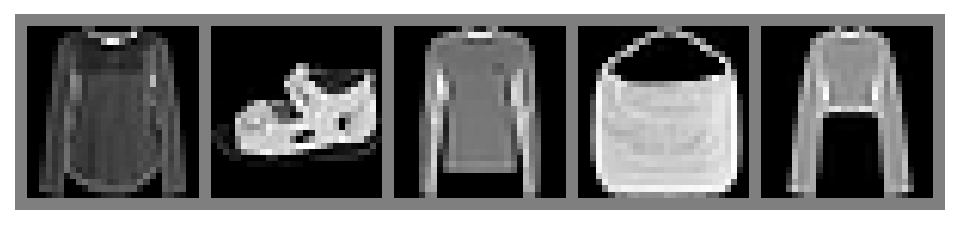

In [7]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np

# Functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    
    figure(num=None, figsize=(8, 6), dpi=150, edgecolor='k')
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

## Build CNN Model

In [20]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self, xdim, conv1_fksp, conv2_fksp, conv3_fksp, pool_ksp, fc1_out, fc2_out, dropout, batch_norm): 
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=conv1_fksp["filter"], kernel_size=conv1_fksp["kernel"], 
                               stride=conv1_fksp["stride"], padding=conv1_fksp["padding"])
        self.conv2 = nn.Conv2d(in_channels=conv1_fksp["filter"], out_channels=conv2_fksp["filter"], kernel_size=conv2_fksp["kernel"],
                               stride=conv2_fksp["stride"], padding=conv2_fksp["padding"])
        self.conv3 = nn.Conv2d(in_channels=conv2_fksp["filter"], out_channels=conv3_fksp["filter"], kernel_size=conv3_fksp["kernel"],
                               stride=conv3_fksp["stride"], padding=conv3_fksp["padding"])
        self.pool = nn.AvgPool2d(pool_ksp["kernel"], pool_ksp["stride"], pool_ksp["padding"])
        self.conv1_bn = nn.BatchNorm2d(conv1_fksp["filter"])
        self.conv2_bn = nn.BatchNorm2d(conv2_fksp["filter"])
        self.conv3_bn = nn.BatchNorm2d(conv3_fksp["filter"])
        self.Dropout = nn.Dropout(dropout)

        dconv1=int((xdim+2*conv1_fksp["padding"]-(conv1_fksp["kernel"]-conv1_fksp["stride"]))/conv1_fksp["stride"])
        dpool1=int((dconv1+2*pool_ksp["padding"]-(pool_ksp["kernel"]-pool_ksp["stride"]))/pool_ksp["stride"])
        dconv2=int((dpool1+2*conv2_fksp["padding"]-(conv2_fksp["kernel"]-conv2_fksp["stride"]))/conv2_fksp["stride"])
        dpool2=int((dconv2+2*pool_ksp["padding"]-(pool_ksp["kernel"]-pool_ksp["stride"]))/pool_ksp["stride"])
        dconv3=int((dpool2+2*conv3_fksp["padding"]-(conv3_fksp["kernel"]-conv3_fksp["stride"]))/conv3_fksp["stride"])
        dpool3=int((dconv3+2*pool_ksp["padding"]-(pool_ksp["kernel"]-pool_ksp["stride"]))/pool_ksp["stride"])
        self.FCinput = conv3_fksp["filter"] * dpool3 * dpool3

        self.batch_norm = batch_norm
        self.fc1 = nn.Linear(self.FCinput, fc1_out)
        self.fc2 = nn.Linear(fc1_out, fc2_out)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.conv1_bn(x) if self.batch_norm == True else x
        x = self.pool(F.relu(self.conv2(x))) 
        x = self.conv2_bn(x) if self.batch_norm == True else x
        x = self.pool(F.relu(self.conv3(x)))
        x = self.conv3_bn(x) if self.batch_norm == True else x
        x = self.Dropout(x)

        x = x.view(-1, self.FCinput)
        x = F.relu(self.fc1(x))
        #x = F.softmax(self.fc2(x),1) #dont need softmax here again
        return x


### Initialize models

In [21]:
# Create inputs

# Input dimension
xdim = trainset[0][0].shape[1]

# Parameters (fixed)
conv1_fksp_base_ls = [32,5,1,2]
conv2_fksp_base_ls = [32,5,1,2]
conv3_fksp_base_ls = [64,5,1,2]
fc1_out_base = 64
fc2_out_base =10

def createConvDic(ls):
    dic = {}
    dic["filter"] = int(ls[0])
    dic["kernel"] = int(ls[1])
    dic["stride"] = int(ls[2])
    dic["padding"] = int(ls[3])
    return dic

conv1_fksp_base = createConvDic(conv1_fksp_base_ls)
conv2_fksp_base = createConvDic(conv2_fksp_base_ls)
conv3_fksp_base = createConvDic(conv3_fksp_base_ls)


# Parameters (tuning)
pool_ksp_base1_ls = [2,2,0]
pool_ksp_base2_ls = [4,3,1]
dropout = [0.1,0.3,0.5]
batch_norm = [True,False]

def createPoolDic(ls):
    dic = {}
    dic["kernel"] = int(ls[0])
    dic["stride"] = int(ls[1])
    dic["padding"] = int(ls[2])
    return dic

pool_ksp_base1 = createPoolDic(pool_ksp_base1_ls)
pool_ksp_base2 = createPoolDic(pool_ksp_base2_ls)

In [22]:
# Save all 12 nets
nets_init =[]
tuning_params = []
for i, x in enumerate([pool_ksp_base1, pool_ksp_base2]):
    for j, y in enumerate(dropout):
        for k, z in enumerate(batch_norm):
            tuning_params.append([x,y,z])
            exec("nets_init.append(Net(xdim = xdim, conv1_fksp = conv1_fksp_base, conv2_fksp = conv2_fksp_base, conv3_fksp = conv3_fksp_base, pool_ksp = x, fc1_out = fc1_out_base, fc2_out = fc2_out_base, dropout=y, batch_norm=z))")

len(nets_init)

12

In [23]:
# Preserve the initialization
nets = nets_init

## Train Models

In [28]:
import torch.optim as optim

def train_CNN_MNIST(model, model_name, epochNum):
    
    # Train model
    model.train()
    
    # Create logger and prepare for logging
    logdir = os.path.join("logs", model_name, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    logger = Logger(logdir)
    overall_step = 0
    
    # initialize criterion and optimizer 
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) #momentum=0.9

    # Set number of epochs
    epochs = epochNum

    # Start looping over epochs
    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss = 0
        epoch_loss = 0
        total = 0
        correct = 0
        loss_200 = []
        accuracy_200 = []
        
        # Start looping for all batches
        for i, data in enumerate(trainloader, 0):
            
            # get the inputs
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels) #forward
            loss.backward() #backward
            optimizer.step() #optimize

            # pred = torch.nn.functional.softmax(pred, dim=1)
            _, predicted = torch.max(outputs.data, 1)
            correct += predicted.eq(labels.reshape(len(labels),)).sum() 
            total += float(len(labels))
            accuracy = correct / total

            # print statistics and save loss and accuracy for every 200 batches
            running_loss += loss.item()
            epoch_loss += loss.item()
        
            if i % 200 == 199:    # print every 200 mini-batches
                
                # print('Epoch: %d, Batch: %5d, loss: %.3f' %
                #       (epoch + 1, i + 1, running_loss / 200))
                
                running_loss = 0.0

                loss_200.append(loss.item())
                accuracy_200.append(accuracy.item())

                info = {'loss' : loss.item(), 'accuracy': accuracy.item()}
                for tag, value in info.items():
                    overall_step+=1
                    logger.scalar_summary(tag, value, overall_step)
        
        # Print avg loss for every epoch
        print('Epoch ',epoch,'; Epoch Avg Loss: ', epoch_loss/len(trainloader), '; Loss Item: ', loss.item()) #
    
    
    # Save model, loss and accuracy for every 200 batches
    PATH='./model_results/'+model_name+'.pt'
    torch.save({"state":model.state_dict(),
                "loss_200":loss_200,
                "accuracy_200":accuracy_200}, PATH)
    
    # Finish Msg
    print('Finished Training')

Perform Training and Parameter Tuning

In [29]:
train_CNN_MNIST(nets[0], "model0", 10)

Epoch  0 ; Epoch Avg Loss:  0.4257061731192128 ; Loss Item:  0.008327875286340714
Epoch  1 ; Epoch Avg Loss:  0.2980645851070318 ; Loss Item:  0.030627692118287086
Epoch  2 ; Epoch Avg Loss:  0.2597943559924582 ; Loss Item:  0.15832750499248505
Epoch  3 ; Epoch Avg Loss:  0.2348552935316875 ; Loss Item:  0.005805750377476215
Epoch  4 ; Epoch Avg Loss:  0.21492399987222233 ; Loss Item:  0.17290128767490387
Epoch  5 ; Epoch Avg Loss:  0.19828825651185647 ; Loss Item:  0.15373003482818604
Epoch  6 ; Epoch Avg Loss:  0.18268045453888831 ; Loss Item:  0.26484328508377075
Epoch  7 ; Epoch Avg Loss:  0.17098416325347407 ; Loss Item:  0.05962168052792549
Epoch  8 ; Epoch Avg Loss:  0.16146739040640615 ; Loss Item:  0.7346031665802002
Epoch  9 ; Epoch Avg Loss:  0.14960821227911902 ; Loss Item:  5.430599412648007e-05
Finished Training


In [30]:
%load_ext tensorboard
%tensorboard --logdir logs

## Test Accuracy

In [31]:
def test_CNN_MNIST(model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    #TODO : Report this accuracy in your report.

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))

In [32]:
test_CNN_MNIST(nets[0])

Accuracy of the network on the 10000 test images: 91 %


## Class Accuracy

In [35]:
def acc_per_class(model):   
    model.eval()
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1


    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

In [36]:
acc_per_class(nets[0])

Accuracy of T-shirt/top : 83 %
Accuracy of Trouser : 97 %
Accuracy of Pullover : 87 %
Accuracy of Dress : 89 %
Accuracy of  Coat : 81 %
Accuracy of Sandal : 98 %
Accuracy of Shirt : 78 %
Accuracy of Sneaker : 94 %
Accuracy of   Bag : 98 %
Accuracy of Ankle boot : 97 %
